<a href="https://colab.research.google.com/github/whiteribbonalliance/womenshealthandwellbeing_public/blob/main/multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Women’s Health and Wellbeing Training Script

Dashboard URL: https://explore.whiteribbonalliance.org/en/healthwellbeing

This notebook contains the code you will need to train your own NLU on our data.

# About the campaign and analysis

Our campaign gathered 1,152,551 responses from 13 countries.

We categorised them using a Transformer model called BERT – trained on about 8,000 training examples. The training examples came from WRA and were augmented by taking more data from the What Women Want campaign and tagging with other tools such as OpenAI. Our overall accuracy was 78% across languages. We have experimented with developing an array of multilingual (language specific) models, but for this project we used the English translations of non-English texts, as this made the model development easier, since we only needed to develop and quality control a single model. Languages where the classification was particularly tricky included Swahili, Hindi and Arabic, especially those responses in Hindi which mixed English and Hindi or included Hindi in English letters (Hinglish and Roman Hindi). In general the languages where the NLP and NLU was particularly challenging were not languages with smaller total numbers of speakers, but rather languages of the Global South which have been historically underserved by language technology.

The classification task was particularly difficult because we are performing multi-label classification rather than single-label classification (that is, each response can be assigned to one or more categories). When the task is single-label classification, a model receives a low score if it mis-assigns one category, whereas for multi-label classification, a response could correctly belong to three categories and the model might assign it only to two of those categories, and receive an accuracy of 67% on that response. The task is harder and so high accuracy scores are less attainable.

Before Running the code make sure you have enabled GPU.



You can enable GPU using this. Runtime >> Change runtime type >> T4 GPU

In [1]:
!pip install simpletransformers

In [2]:
!wget https://raw.githubusercontent.com/whiteribbonalliance/womenshealthandwellbeing_public/main/cleaned_labeled_data.xlsx

--2024-01-13 13:58:35--  https://raw.githubusercontent.com/whiteribbonalliance/womenshealthandwellbeing_public/main/cleaned_labeled_data.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273845 (267K) [application/octet-stream]
Saving to: ‘cleaned_labeled_data.xlsx.1’

cleaned_labeled_dat 100%[===================>] 267.43K  --.-KB/s    in 0.02s   

2024-01-13 13:58:35 (14.2 MB/s) - ‘cleaned_labeled_data.xlsx.1’ saved [273845/273845]



**Data preparation**

In [3]:
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Load the data from the Excel file
data = pd.read_excel("cleaned_labeled_data.xlsx")


In [4]:
data['text'] = data['text'].str.lower()

In [5]:
data.columns

Index(['Unnamed: 0', 'text', 'demands'], dtype='object')

In [6]:
data.shape

(7914, 3)

In [7]:
### check distribution of onme demands vs more demands

import ast

# Convert the string representation of lists to actual lists
data['demands_list'] = data['demands'].apply(ast.literal_eval)

# Calculate the number of demands for each row
data['num_demands'] = data['demands_list'].apply(len)

# Count rows with more than one demand and rows with only one demand
more_than_one_demand = (data['num_demands'] > 1).sum()
only_one_demand = (data['num_demands'] == 1).sum()

more_than_one_demand, only_one_demand


(1936, 5978)

In [8]:
# Flatten the lists in the 'demands_list' column to get individual demands
all_demands = [demand for sublist in data['demands_list'] for demand in sublist]

# Count the occurrences of each demand
demand_distribution = pd.Series(all_demands).value_counts()

demand_distribution


Fully-functional and well-equipped Health Facilities      772
Education and Vocational Skills                           772
Water, Sanitation & Hygiene                               761
High Quality, Inclusive and Respectful Health Services    722
Free, Affordable or Insured Healthcare                    618
Work & Financial Support                                  557
Food and Adequate Nutrition                               548
Health Workers                                            431
No Harmful Practices and GBV                              414
Policy and Social Welfare                                 396
Autonomy, Equality, and Empowerment                       377
Transportation and Road Safety                            367
Safety                                                    365
Interpersonal Relationships and Social Support            364
Cancer                                                    360
Maternal, Newborn, Child Health                           334
Sexual a

In [9]:

# # Drop the unnecessary unnamed index column
# data.drop(columns=['Unnamed: 0'], inplace=True)

def transform_complete_data(df):
    """Transforms the entire data."""
    # Convert the string representation of list to actual list
    df['demands'] = df['demands'].apply(ast.literal_eval)

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # Fit and transform the 'demands' column to get the binary matrix
    binary_matrix = mlb.fit_transform(df['demands'])

    # Convert the binary matrix to a DataFrame
    binary_df = pd.DataFrame(binary_matrix, columns=mlb.classes_)

    # Concatenate the original data with the binary DataFrame
    prepared_df = pd.concat([df['text'], binary_df], axis=1)

    return prepared_df, mlb

# Transform the entire data
prepared_data, mlb = transform_complete_data(data)

# Split the transformed data into training and test sets (80-20)
train_prepared, test_prepared = train_test_split(prepared_data, test_size=0.15, random_state=42)

print(train_prepared.head())
print(test_prepared.head())

                                                   text  \
2087                                   to be given love   
1047             a domestic workers must have a payslip   
2178  to provide some snacks for elderly, some have ...   
1320  discrimination of women living with aids are s...   
414                        knee belt should be provided   

      Autonomy, Equality, and Empowerment  Cancer  Communicable Diseases  \
2087                                    0       0                      0   
1047                                    0       0                      0   
2178                                    0       0                      0   
1320                                    1       0                      0   
414                                     0       0                      0   

      Education and Vocational Skills  Food and Adequate Nutrition  \
2087                                0                            0   
1047                                0           

In [10]:
len(mlb.classes_)

23

**Train the model**

In [12]:
from simpletransformers.classification import ClassificationModel, MultiLabelClassificationModel

# Define the model
model = MultiLabelClassificationModel('bert', 'bert-base-uncased', num_labels=len(mlb.classes_), args={'overwrite_output_dir': True, 'num_train_epochs': 15})

# Split the training data into features and labels
train_data_text = train_prepared['text'].tolist()
train_labels = train_prepared[mlb.classes_].values.tolist()

# Train the model
model.train_model(pd.DataFrame({'text': train_data_text, 'labels': train_labels}))


Some weights of BertForMultiLabelSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6726 [00:00<?, ?it/s]

Process ForkPoolWorker-2:


KeyboardInterrupt: 

**Evaluate the model**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

test_prepared.dropna(subset=['text'], inplace=True)

# Split the test data into features and labels
test_data_text = test_prepared['text'].tolist()



test_labels = test_prepared[mlb.classes_].values

# Get predictions for the test set
predictions, raw_outputs = model.predict(test_data_text)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)

# Generate a classification report
report = classification_report(test_labels, predictions, target_names=mlb.classes_)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)


  0%|          | 0/1188 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Accuracy: 0.67003367003367

Classification Report:
                                                         precision    recall  f1-score   support

                   Autonomy, Equality, and Empowerment       0.71      0.71      0.71        59
                                                Cancer       1.00      0.91      0.95        58
                                 Communicable Diseases       0.87      0.72      0.79        36
                       Education and Vocational Skills       0.84      0.87      0.85       113
                           Food and Adequate Nutrition       0.89      0.98      0.93        82
                Free, Affordable or Insured Healthcare       0.77      0.81      0.79        94
  Fully-functional and well-equipped Health Facilities       0.81      0.76      0.78       127
                                        Health Workers       0.67      0.67      0.67        63
High Quality, Inclusive and Respectful Health Services       0.58      0.61      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
index_to_label = {i: label for i, label in enumerate(mlb.classes_)}
index_to_label

{0: 'Autonomy, Equality, and Empowerment',
 1: 'Cancer',
 2: 'Communicable Diseases',
 3: 'Education and Vocational Skills',
 4: 'Food and Adequate Nutrition',
 5: 'Free, Affordable or Insured Healthcare',
 6: 'Fully-functional and well-equipped Health Facilities',
 7: 'Health Workers',
 8: 'High Quality, Inclusive and Respectful Health Services',
 9: 'Interpersonal Relationships and Social Support',
 10: 'Maternal, Newborn, Child Health',
 11: 'Menstrual & Menopausal Cycles',
 12: 'Mental Health',
 13: 'No Harmful Practices and GBV',
 14: 'Non-Communicable Diseases',
 15: 'Physical Activity and Rest',
 16: 'Policy and Social Welfare',
 17: 'Safety',
 18: 'Sexual and Reproductive Health',
 19: 'Sustainable Energy & Agriculture',
 20: 'Transportation and Road Safety',
 21: 'Water, Sanitation & Hygiene',
 22: 'Work & Financial Support'}

  0%|          | 0/1188 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

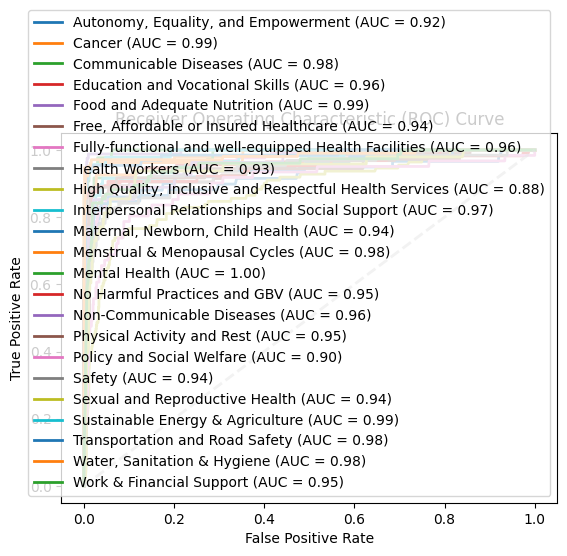

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from simpletransformers.classification import MultiLabelClassificationModel

# Load the trained model
#model = MultiLabelClassificationModel('model_type', 'path_to_saved_model_directory')

# Extract the text data from the dataframe for prediction
texts = test_prepared['text'].tolist()

# Use the model to predict
predictions, raw_outputs = model.predict(texts)

# List to store AUC values for each category
all_aucs = {}

# Iterate over each category
for cat_no, label in index_to_label.items():

    # Get ground truths from the dataframe (one-hot encoded structure)
    all_gts = test_prepared[label].values

    # Get predicted probabilities from raw_outputs for the current category
    all_probas = raw_outputs[:, cat_no]

    # Calculate ROC curve values
    fpr, tpr, _ = roc_curve(all_gts, all_probas)

    # Calculate AUC
    this_auc = auc(fpr, tpr)
    all_aucs[label] = this_auc

    # Plot ROC curve for the current category
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {this_auc:.2f})")

# Plot reference line
plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=2, linestyle="--")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()


In [ ]:
all_aucs

{'Autonomy, Equality, and Empowerment': 0.9182642506492922,
 'Cancer': 0.9886328959414098,
 'Communicable Diseases': 0.9756703317901234,
 'Education and Vocational Skills': 0.9585511422103312,
 'Food and Adequate Nutrition': 0.9949719931195695,
 'Free, Affordable or Insured Healthcare': 0.9395688280368742,
 'Fully-functional and well-equipped Health Facilities': 0.9611828092647703,
 'Health Workers': 0.9342857142857143,
 'High Quality, Inclusive and Respectful Health Services': 0.8804779710072189,
 'Interpersonal Relationships and Social Support': 0.9671375598624852,
 'Maternal, Newborn, Child Health': 0.9390070298769772,
 'Menstrual & Menopausal Cycles': 0.9818004912750822,
 'Mental Health': 0.9963440641819844,
 'No Harmful Practices and GBV': 0.9513178380782917,
 'Non-Communicable Diseases': 0.9575238459820716,
 'Physical Activity and Rest': 0.9479046103395061,
 'Policy and Social Welfare': 0.896337294718315,
 'Safety': 0.9403428047153024,
 'Sexual and Reproductive Health': 0.9419499

{'Autonomy, Equality, and Empowerment': 0.9182642506492922,
 'Cancer': 0.9886328959414098,
 'Communicable Diseases': 0.9756703317901234,
 'Education and Vocational Skills': 0.9585511422103312,
 'Food and Adequate Nutrition': 0.9949719931195695,
 'Free, Affordable or Insured Healthcare': 0.9395688280368742,
 'Fully-functional and well-equipped Health Facilities': 0.9611828092647703,
 'Health Workers': 0.9342857142857143,
 'High Quality, Inclusive and Respectful Health Services': 0.8804779710072189,
 'Interpersonal Relationships and Social Support': 0.9671375598624852,
 'Maternal, Newborn, Child Health': 0.9390070298769772,
 'Menstrual & Menopausal Cycles': 0.9818004912750822,
 'Mental Health': 0.9963440641819844,
 'No Harmful Practices and GBV': 0.9513178380782917,
 'Non-Communicable Diseases': 0.9575238459820716,
 'Physical Activity and Rest': 0.9479046103395061,
 'Policy and Social Welfare': 0.896337294718315,
 'Safety': 0.9403428047153024,
 'Sexual and Reproductive Health': 0.9419499

##Inference code

In [4]:
from simpletransformers.classification import ClassificationModel, MultiLabelClassificationModel
from scipy.special import softmax
from sklearn.preprocessing import LabelBinarizer

# Specify the path to your saved model
#saved_model_dir = r"/content/drive/MyDrive/Thomas/sub_category_24/model_09_10"
saved_model_dir = "amoldwalunj/BERT_multi_label_classification_survey_repose_classification"

# Load the model from the checkpoint
model = MultiLabelClassificationModel("bert", saved_model_dir, use_cuda=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [5]:
index_to_label= {0: 'Autonomy, Equality, and Empowerment',
 1: 'Cancer',
 2: 'Communicable Diseases',
 3: 'Education and Vocational Skills',
 4: 'Food and Adequate Nutrition',
 5: 'Free, Affordable or Insured Healthcare',
 6: 'Fully-functional and well-equipped Health Facilities',
 7: 'Health Workers',
 8: 'High Quality, Inclusive and Respectful Health Services',
 9: 'Interpersonal Relationships and Social Support',
 10: 'Maternal, Newborn, Child Health',
 11: 'Menstrual & Menopausal Cycles',
 12: 'Mental Health',
 13: 'No Harmful Practices and GBV',
 14: 'Non-Communicable Diseases',
 15: 'Physical Activity and Rest',
 16: 'Policy and Social Welfare',
 17: 'Safety',
 18: 'Sexual and Reproductive Health',
 19: 'Sustainable Energy & Agriculture',
 20: 'Transportation and Road Safety',
 21: 'Water, Sanitation & Hygiene',
 22: 'Work & Financial Support'}

In [6]:
# Create a dictionary mapping from index to class name
#index_to_label = {i: label for i, label in enumerate(mlb.classes_)}

def labels_from_predictions(predictions):
    """Convert predictions to label names using the index_to_label dictionary."""
    return [[index_to_label[idx] for idx, val in enumerate(row) if val == 1] for row in predictions]

def predict_single(text):
    """Predict the labels for a single text input."""
    predictions, _ = model.predict([text])
    return labels_from_predictions(predictions)[0]

def predict_batch(texts):
    """Predict the labels for a batch of text inputs."""
    predictions, _ = model.predict(texts)
    return labels_from_predictions(predictions)

# def predict_dataframe(df):
#     """Predict the labels for an entire dataframe and add them to a new 'demands' column."""
#     texts = df['text'].tolist()
#     predictions, _ = model.predict(texts)
#     df['demands'] = labels_from_predictions(predictions)
#     return df

def predict_dataframe(df):
    """Predict the labels for an entire dataframe and add them to a new 'demands' column."""
    texts = df['text_lower'].tolist()
    predictions, _ = model.predict(texts)
    df['demands'] = labels_from_predictions(predictions)
    return df

# Example usage:
single_text = "how to fight seasonal fever"
print(predict_single(single_text))


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

['Communicable Diseases']


In [ ]:
import pandas as pd
df_infer= pd.read_csv(r'/content/missing_translated.csv')

In [ ]:
df_infer['text_lower'] = df_infer['text'].str.lower()

In [ ]:
df= predict_dataframe(df_infer)

  0%|          | 0/4335 [00:00<?, ?it/s]

  0%|          | 0/542 [00:00<?, ?it/s]